In [2]:
import os
import tqdm
import numpy as np

import torch
import torch.nn as nn
# import torch.nn.functional as F
import torch.optim as optim
import torchvision
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


import torch
from torch import nn, optim
from torch.nn import functional as F

# calibration
class ModelWithTemperature(nn.Module):
    """
    A thin decorator, which wraps a model with temperature scaling
    model (nn.Module):
        A classification neural network
        NB: Output of the neural network should be the classification logits,
            NOT the softmax (or log softmax)!
    """
    def __init__(self, model):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, input):
        logits = self.model(input)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        """
        Perform temperature scaling on logits
        """
        # Expand temperature to match the size of logits
        temperature = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
        return logits / temperature

    # This function probably should live outside of this class, but whatever
    def set_temperature(self, valid_loader):
        """
        Tune the tempearature of the model (using the validation set).
        We're going to set it to optimize NLL.
        valid_loader (DataLoader): validation set loader
        """
        self.cuda()
        nll_criterion = nn.CrossEntropyLoss().cuda()
        ece_criterion = _ECELoss().cuda()

        # First: collect all the logits and labels for the validation set
        logits_list = []
        labels_list = []
        with torch.no_grad():
            for input, label in valid_loader:
                input = input.cuda()
                logits = self.model(input)
                logits_list.append(logits)
                labels_list.append(label)
            logits = torch.cat(logits_list).cuda()
            labels = torch.cat(labels_list).cuda()

        # Calculate NLL and ECE before temperature scaling
        before_temperature_nll = nll_criterion(logits, labels).item()
        before_temperature_ece = ece_criterion(logits, labels).item()
        print('Before temperature - NLL: %.3f, ECE: %.3f' % (before_temperature_nll, before_temperature_ece))

        # Next: optimize the temperature w.r.t. NLL
        optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=50)

        def eval():
            optimizer.zero_grad()
            loss = nll_criterion(self.temperature_scale(logits), labels)
            loss.backward()
            return loss
        optimizer.step(eval)

        # Calculate NLL and ECE after temperature scaling
        after_temperature_nll = nll_criterion(self.temperature_scale(logits), labels).item()
        after_temperature_ece = ece_criterion(self.temperature_scale(logits), labels).item()
        print('Optimal temperature: %.3f' % self.temperature.item())
        print('After temperature - NLL: %.3f, ECE: %.3f' % (after_temperature_nll, after_temperature_ece))

        return self

# estimate uncertainty
class _ECELoss(nn.Module):
    """
    Calculates the Expected Calibration Error of a model.
    (This isn't necessary for temperature scaling, just a cool metric).
    The input to this loss is the logits of a model, NOT the softmax scores.
    This divides the confidence outputs into equally-sized interval bins.
    In each bin, we compute the confidence gap:
    bin_gap = | avg_confidence_in_bin - accuracy_in_bin |
    We then return a weighted average of the gaps, based on the number
    of samples in each bin
    See: Naeini, Mahdi Pakdaman, Gregory F. Cooper, and Milos Hauskrecht.
    "Obtaining Well Calibrated Probabilities Using Bayesian Binning." AAAI.
    2015.
    """
    def __init__(self, n_bins=15):
        """
        n_bins (int): number of confidence interval bins
        """
        super(_ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, logits, labels):
        softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)

        ece = torch.zeros(1, device=logits.device)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece

%load_ext autoreload
%autoreload 1
%aimport utils_data
%aimport utils_model
%aimport utils_attack

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Datasets and dataloaders preparation 

In [4]:
(train_set_10, test_set_10), (train_loader_10, test_loader_10) = utils_data.get_train_test_dataloaders(
    dataset_type='cifar10', 
    root_data_folder='./data', 
    batch_size=64
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10
Files already downloaded and verified


In [5]:
(train_set_100, test_set_100), (train_loader_100, test_loader_100) = utils_data.get_train_test_dataloaders(
    dataset_type='cifar100', 
    root_data_folder='./data', 
    batch_size=64
)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar100/cifar-100-python.tar.gz to ./data/cifar100
Files already downloaded and verified


# Model

## Loading and fine-tuning ResNet50 pretrained on ImageNet 
**(you can skip this part if you already have a model pretrained on CIFAR10/100)**

In [11]:
utils_data.set_random_seeds(seed_value=123, device=device)
criterion = nn.CrossEntropyLoss()

'''source https://github.com/kuangliu/pytorch-cifar/blob/master/main.py'''
optimizer_10 = optim.SGD(model_10.parameters(), lr=1e-3,
                      momentum=0.9, weight_decay=5e-4)
scheduler_10 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_10, T_max=200)

## Load a model pretrained on CIFAR10 and model with temperature scaling
**to load pretrained model uncomment the cell below**

In [8]:
#path_to_model_save = './models'
model_10 = torchvision.models.resnet50(pretrained=True)
model_10.fc = nn.Linear(in_features=2048, out_features=10, bias=True)
model_10.load_state_dict(
    torch.load('cifar10.pt')
)
model_10 = model_10.to(device)

In [9]:
model_10_t = ModelWithTemperature(model_10)

In [46]:
model_10

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# FGSM attack

In [13]:
results_df_10 = utils_attack.test_robustness_simple(
    model_10,
    test_loader_10,
    criterion,
    (1e-3, 1e0, 20), # (1e-3, 1e0, 20),
    attack_type="fgsm",
    n_samples_ret=5,
    device=device
)
results_df_10

100%|██████████| 20/20 [09:54<00:00, 29.74s/it]


Metric,Accuracy
Noise sigma,
0.001000,0.8503
0.001438,0.8448
0.002069,0.8342
0.002976,0.8190
0.004281,0.7963
0.006158,0.7663
0.008859,0.7209
0.012743,0.6589
0.018330,0.5822


In [14]:
model_10_t = model_10_t.to(device)

results_df_10_t = utils_attack.test_robustness_simple(
    model_10_t,
    test_loader_10,
    criterion,
    (1e-3, 1e0, 20), # (1e-3, 1e0, 20),
    attack_type="fgsm",
    n_samples_ret=5,
    device=device
)
results_df_10_t

100%|██████████| 20/20 [09:54<00:00, 29.75s/it]


Metric,Accuracy
Noise sigma,
0.001000,0.8511
0.001438,0.8452
0.002069,0.8350
0.002976,0.8197
0.004281,0.7982
0.006158,0.7681
0.008859,0.7236
0.012743,0.6645
0.018330,0.5862


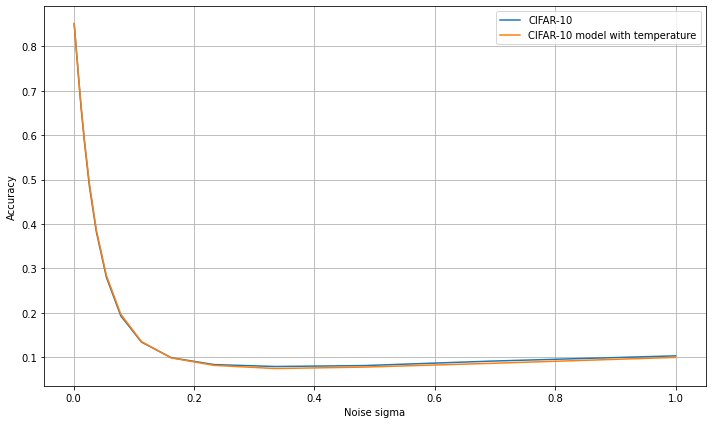

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(results_df_10.index, results_df_10['Accuracy'], label='CIFAR-10')
ax.plot(results_df_10_t.index, results_df_10_t['Accuracy'], label='CIFAR-10 model with temperature')
ax.set_xlabel('Noise sigma')
ax.set_ylabel('Accuracy')
ax.grid(visible=True)
ax.legend()

plt.tight_layout()
plt.show()

In [16]:
all_preds_10, all_preds_10_t = torch.tensor([], device=device), torch.tensor([], device=device)
all_labels_10, all_labels_10_t =  torch.tensor([], device=device), torch.tensor([], device=device)
# for images, labels in tqdm(test_loader_10):
for images, labels in test_loader_10:
    images, labels = images.to(device), labels.to(device)
    pred_10 = model_10(images)
    all_preds_10 = torch.cat([all_preds_10, pred_10.argmax(axis=1)])
    all_labels_10 = torch.cat([all_labels_10, labels])
    
for images, labels in test_loader_10:
    images, labels = images.to(device), labels.to(device)
    pred_10_t = model_10_t(images)
    all_preds_10_t = torch.cat([all_preds_10_t, pred_10_t.argmax(axis=1)])
    all_labels_10_t = torch.cat([all_labels_10_t, labels])
    
acc_10 = accuracy_score(all_labels_10.detach().cpu().numpy(), all_preds_10.detach().cpu().numpy())
acc_10_t = accuracy_score(all_labels_10_t.detach().cpu().numpy(), all_preds_10_t.detach().cpu().numpy())
acc_10, acc_10_t

(0.8653, 0.8653)

ECE metric

In [17]:
all_preds_10_np = all_preds_10.detach().cpu().numpy()
all_preds_10_t_np = all_preds_10_t.detach().cpu().numpy()

In [47]:
preds_class_change_10

array([3., 8., 1., ..., 5., 1., 7.], dtype=float32)

In [18]:
preds_class_change_10, radii_class_change_10 = utils_attack.get_adversarial_radii(
    model_10,
    all_preds_10_np,
    dataloader=test_loader_10,
    loss=criterion,
    num_samples=10000,
    min_v=1e-4,
    max_v=1000,
    step_v=2 ** 0.5,
    method="fgsm",
    device=device,
)

preds_class_change_10_t, radii_class_change_10_t = utils_attack.get_adversarial_radii(
    model_10_t,
    all_preds_10_t_np,
    dataloader=test_loader_10,
    loss=criterion,
    num_samples=10000,
    min_v=1e-4,
    max_v=1000,
    step_v=2 ** 0.5,
    method="fgsm",
    device=device,
)

100%|██████████| 47/47 [23:20<00:00, 29.80s/it]


In [ ]:
# finite_radii_class_change_mask.shape, radii_inv_class_change.shape, finite_radii_class_change_mask.sum()

In [27]:
radii_inv_class_change_10_t = -radii_class_change_10_t
finite_radii_class_change_mask_10_t = radii_inv_class_change_10_t != -np.inf
radii_inv_class_change_finite_10_t = radii_inv_class_change_10_t[finite_radii_class_change_mask_10_t]
preds_class_change_10_t = all_preds_10_t_np[finite_radii_class_change_mask_10_t]

radii_inv_class_change_10 = -radii_class_change_10
finite_radii_class_change_mask_10 = radii_inv_class_change_10 != -np.inf
radii_inv_class_change_finite_10 = radii_inv_class_change_10[finite_radii_class_change_mask_10]
preds_class_change_10 = all_preds_10_np[finite_radii_class_change_mask_10]


In [28]:
radii_class_change_finite_10, radii_class_change_finite_10_t = radii_class_change_10[finite_radii_class_change_mask_10],radii_class_change_10_t[finite_radii_class_change_mask_10_t]

In [29]:
finite_radii_class_change_mask_10.mean(), finite_radii_class_change_mask_10_t.mean()

(0.9999, 0.9999)

In [30]:
min_eps = 1e-4
max_eps = 1e3
step_eps = 2 ** 0.5
num_eps = int((np.log10(max_eps) - np.log10(min_eps)) / np.log10(step_eps)) + 1
bins = list(np.geomspace(min_eps, max_eps, num_eps))

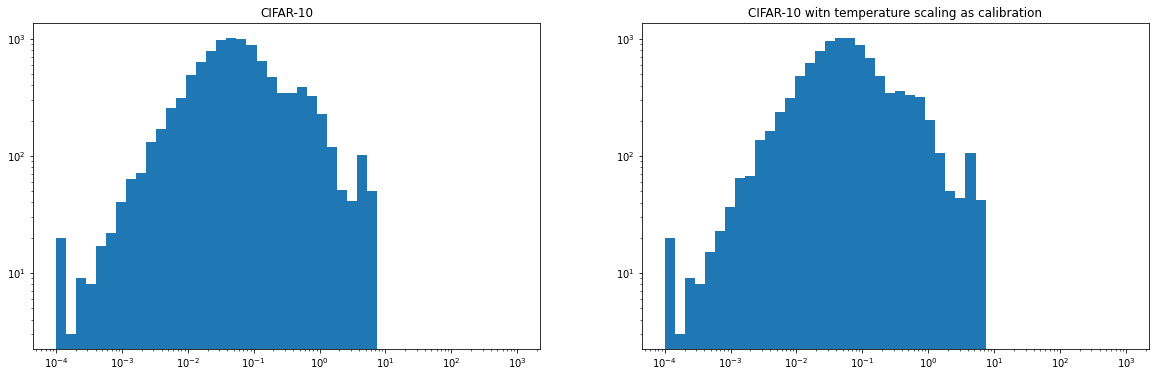

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
ax[0].hist(radii_class_change_finite_10, bins=bins);
ax[0].set_title('CIFAR-10')
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[1].hist(radii_class_change_finite_10_t, bins=bins);
ax[1].set_title('CIFAR-10 witn temperature scaling as calibration')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

In [32]:
from functools import partial

def get_radii_preds_func(radii, preds):
    return preds, radii

get_radii_inv_partial_class_change_10 = partial(get_radii_preds_func, radii_inv_class_change_10)
get_radii_inv_partial_class_change_10_t = partial(get_radii_preds_func, radii_inv_class_change_10_t)

In [33]:
rejection_rates = np.linspace(0, 1.0, 20)

radii_accs_class_change_10 = utils_attack.reject_by_metric(
    get_radii_inv_partial_class_change_10,
    all_preds_10_np,
    all_labels_10.detach().cpu().numpy(),
    rejection_rates,
    accuracy_score
)
radii_accs_class_change_10_t = utils_attack.reject_by_metric(
    get_radii_inv_partial_class_change_10_t,
    all_preds_10_t_np,
    all_labels_10_t.detach().cpu().numpy(),
    rejection_rates,
    accuracy_score
)

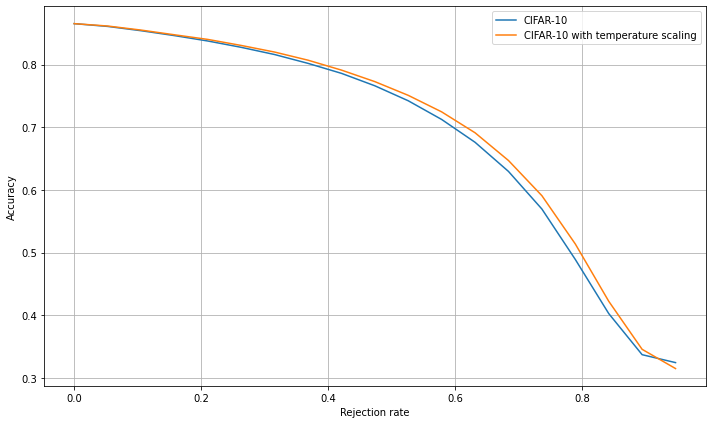

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

perf_metrics = [radii_accs_class_change_10, radii_accs_class_change_10_t]
line_labels = ['CIFAR-10', 'CIFAR-10 with temperature scaling']

for metric, label in zip(perf_metrics, line_labels):
    ax.plot(rejection_rates[0:len(metric)], metric, label=label)
ax.set_xlabel('Rejection rate')
ax.set_ylabel('Accuracy')
ax.grid(visible=True)
ax.legend()

plt.tight_layout()
plt.show()